In [1]:
# Cell 1: Install required libraries
!pip install mediapipe opencv-python pandas numpy matplotlib scipy scikit-learn -q
!pip install ffmpeg-python -q
!pip install mediapipe -q  # Ensure mediapipe is installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.9 MB/s eta 0:00:00


In [2]:
# Cell 2: Import all necessary libraries
import cv2
import numpy as np
import pandas as pd
import json
import csv
import os
from scipy.signal import savgol_filter
import math
from google.colab import files
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')

# Import MediaPipe Tasks (new API only)
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

print("All libraries imported successfully")
print("OpenCV version:", cv2.__version__)
print("MediaPipe version:", mp.__version__)

All libraries imported successfully
OpenCV version: 4.13.0
MediaPipe version: 0.10.32


In [18]:
!pip freeze > requirements.txt

In [19]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Check GPU availability
import tensorflow as tf

print("Checking system configuration...")
gpu_available = tf.test.is_gpu_available()
if gpu_available:
    print("GPU is available for acceleration")
    print(f"GPU Device: {tf.test.gpu_device_name()}")
else:
    print("GPU not detected, running on CPU")
    print("Note: For faster processing, enable GPU via:")
    print("Runtime -> Change runtime type -> Hardware accelerator -> GPU")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Checking system configuration...
GPU is available for acceleration
GPU Device: /device:GPU:0


In [4]:
# Cell 3: Upload your video file
print("Upload your cricket batting video file (e.g., .mp4, .mov, .avi)")
uploaded = files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print("Uploaded file:", video_filename)

Upload your cricket batting video file (e.g., .mp4, .mov, .avi)


Saving Untitled video - Made with Clipchamp (2).mp4 to Untitled video - Made with Clipchamp (2).mp4
Uploaded file: Untitled video - Made with Clipchamp (2).mp4


In [5]:
# Cell 4: Download the pose landmarker model
print("Downloading pose landmarker model...")
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
print("Model downloaded successfully")

Model downloaded successfully


In [6]:
# ADD THIS CELL AFTER Cell 4 (model download) and BEFORE Cell 5 (PoseAnalyzer)
# Enhanced model download with verification
import os
import time

model_filename = 'pose_landmarker.task'

print("Verifying model download...")
if os.path.exists(model_filename):
    file_size = os.path.getsize(model_filename) / (1024 * 1024)
    print(f"Model file found: {file_size:.2f} MB")

    # Check if file is valid (not empty or corrupted)
    if file_size < 10:  # Model should be > 10 MB
        print("Warning: Model file seems too small, re-downloading...")
        !rm -f pose_landmarker.task
        !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
else:
    print("Model file not found. Downloading now...")
    !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

# Final verification
if os.path.exists(model_filename):
    file_size = os.path.getsize(model_filename) / (1024 * 1024)
    print(f"Model ready: {file_size:.2f} MB")
else:
    print("Error: Could not download model file")

Verifying model download...
Model file found: 29.24 MB
Model ready: 29.24 MB


In [7]:
# Cell 5: Initialize MediaPipe Pose Estimator with Tasks API
class PoseAnalyzer:
    def __init__(self):
        # Initialize MediaPipe Pose using Tasks API
        base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
        options = vision.PoseLandmarkerOptions(
            base_options=base_options,
            output_segmentation_masks=False,
            min_pose_detection_confidence=0.5,
            min_pose_presence_confidence=0.5,
            min_tracking_confidence=0.5,
            num_poses=1
        )

        # Create the landmarker
        self.landmarker = vision.PoseLandmarker.create_from_options(options)

        # Define landmark connections manually (since we can't use solutions)
        self.POSE_CONNECTIONS = [
            (0, 1), (1, 2), (2, 3), (3, 7),  # Face
            (0, 4), (4, 5), (5, 6), (6, 8),  # Face
            (9, 10),  # Mouth
            (11, 12),  # Shoulders
            (11, 13), (13, 15),  # Left arm
            (12, 14), (14, 16),  # Right arm
            (11, 23), (12, 24),  # Torso
            (23, 24),  # Hips
            (23, 25), (25, 27), (27, 29), (29, 31),  # Left leg
            (24, 26), (26, 28), (28, 30), (30, 32),  # Right leg
            (15, 17), (15, 19), (15, 21),  # Left hand
            (16, 18), (16, 20), (16, 22)   # Right hand
        ]

        # Landmark indices for key joints
        self.LANDMARK_INDICES = {
            'nose': 0, 'left_eye_inner': 1, 'left_eye': 2, 'left_eye_outer': 3,
            'right_eye_inner': 4, 'right_eye': 5, 'right_eye_outer': 6,
            'left_ear': 7, 'right_ear': 8, 'mouth_left': 9, 'mouth_right': 10,
            'left_shoulder': 11, 'right_shoulder': 12, 'left_elbow': 13,
            'right_elbow': 14, 'left_wrist': 15, 'right_wrist': 16,
            'left_pinky': 17, 'right_pinky': 18, 'left_index': 19,
            'right_index': 20, 'left_thumb': 21, 'right_thumb': 22,
            'left_hip': 23, 'right_hip': 24, 'left_knee': 25, 'right_knee': 26,
            'left_ankle': 27, 'right_ankle': 28, 'left_heel': 29,
            'right_heel': 30, 'left_foot_index': 31, 'right_foot_index': 32
        }

    def process_video(self, video_path):
        """Process video and extract pose landmarks"""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Cannot open video", video_path)
            return None

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print("Video Info:", width, "x", height, ",", fps, "FPS,", total_frames, "frames")

        all_landmarks = []
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert to MediaPipe Image
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

            # Detect pose landmarks
            detection_result = self.landmarker.detect(mp_image)

            if detection_result.pose_landmarks:
                landmarks = []
                for landmark in detection_result.pose_landmarks[0]:
                    landmarks.append({
                        'x': landmark.x,
                        'y': landmark.y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    })
                all_landmarks.append(landmarks)
            else:
                # If no detection, append None
                all_landmarks.append(None)

            frame_count += 1
            if frame_count % 30 == 0:
                print("Processed", frame_count, "/", total_frames, "frames")

        cap.release()
        print("Processing complete. Processed", frame_count, "frames")

        return {
            'landmarks': all_landmarks,
            'video_info': {
                'fps': fps,
                'width': width,
                'height': height,
                'total_frames': frame_count
            }
        }

    def create_skeleton_overlay(self, video_path, output_path='output_with_skeleton.mp4'):
        """Create video with skeleton overlay"""
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Define video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

            # Detect pose landmarks
            detection_result = self.landmarker.detect(mp_image)

            if detection_result.pose_landmarks:
                pose_landmarks = detection_result.pose_landmarks[0]

                # Draw connections
                for connection in self.POSE_CONNECTIONS:
                    start_idx = connection[0]
                    end_idx = connection[1]

                    if start_idx < len(pose_landmarks) and end_idx < len(pose_landmarks):
                        start_point = (
                            int(pose_landmarks[start_idx].x * width),
                            int(pose_landmarks[start_idx].y * height)
                        )
                        end_point = (
                            int(pose_landmarks[end_idx].x * width),
                            int(pose_landmarks[end_idx].y * height)
                        )

                        # Draw line in green
                        cv2.line(frame, start_point, end_point, (0, 255, 0), 2)

                # Draw keypoints
                for landmark in pose_landmarks:
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    # Draw circle in red
                    cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

            # Write frame
            out.write(frame)
            frame_count += 1

            if frame_count % 30 == 0:
                print("Overlayed skeleton on", frame_count, "frames")

        cap.release()
        out.release()
        print("Skeleton overlay video saved to", output_path)
        return output_path

# Initialize the analyzer
analyzer = PoseAnalyzer()
print("Pose Analyzer initialized successfully")

Pose Analyzer initialized successfully


In [8]:
# ADD THIS CELL AFTER Cell 5 (PoseAnalyzer initialization) and BEFORE Cell 6 (process video)
# Performance monitoring wrapper
print("\nPERFORMANCE MONITORING")
print("=" * 50)

import time

# Create a wrapper function for better performance tracking
def process_video_optimized(video_path, max_frames=None):
    """
    Process video with performance monitoring and optional frame limit
    """
    print(f"Starting optimized video processing: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video", video_path)
        return None

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if max_frames:
        total_frames = min(total_frames, max_frames)
        print(f"TEST MODE: Processing first {max_frames} frames only")

    print(f"Video Info: {width}x{height}, {fps} FPS, {total_frames} frames")
    print(f"Estimated time: {total_frames/20:.1f}s with GPU, {total_frames/10:.1f}s with CPU")

    all_landmarks = []
    frame_count = 0
    detection_count = 0

    start_time = time.time()

    while cap.isOpened() and (max_frames is None or frame_count < max_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to MediaPipe Image
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

        # Detect pose landmarks
        try:
            detection_result = analyzer.landmarker.detect(mp_image)

            if detection_result.pose_landmarks:
                landmarks = []
                for landmark in detection_result.pose_landmarks[0]:
                    landmarks.append({
                        'x': landmark.x,
                        'y': landmark.y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    })
                all_landmarks.append(landmarks)
                detection_count += 1
            else:
                all_landmarks.append(None)

        except Exception as e:
            print(f"Error on frame {frame_count}: {e}")
            all_landmarks.append(None)

        frame_count += 1

        # Progress update
        if frame_count % 30 == 0:
            elapsed = time.time() - start_time
            current_fps = frame_count / elapsed if elapsed > 0 else 0
            print(f"Progress: {frame_count}/{total_frames} frames ({current_fps:.1f} FPS)")

    cap.release()

    # Calculate statistics
    elapsed = time.time() - start_time
    detection_rate = (detection_count / frame_count * 100) if frame_count > 0 else 0

    print("\n" + "=" * 50)
    print("PROCESSING COMPLETE")
    print(f"Total frames: {frame_count}")
    print(f"Frames with pose detected: {detection_count} ({detection_rate:.1f}%)")
    print(f"Processing time: {elapsed:.1f} seconds")
    print(f"Average speed: {frame_count/elapsed:.1f} FPS")
    print("=" * 50)

    return {
        'landmarks': all_landmarks,
        'video_info': {
            'fps': fps,
            'width': width,
            'height': height,
            'total_frames': frame_count,
            'detection_rate': detection_rate
        },
        'processing_stats': {
            'total_time': elapsed,
            'frames_per_second': frame_count/elapsed if elapsed > 0 else 0
        }
    }

# Option for test mode (process fewer frames)
test_mode = False  # Set to True to process only 100 frames for testing
max_frames = 100 if test_mode else None

if test_mode:
    print("TEST MODE ENABLED - Processing only 100 frames")
    print("Set test_mode = False for full processing")


PERFORMANCE MONITORING


In [9]:
# REPLACE Cell 6 with this optimized version:
print("Processing video for pose estimation...")
print("=" * 50)

# Use the optimized processing function
results = process_video_optimized(video_filename, max_frames=max_frames)

if results:
    print("\nVideo processing results:")
    print(f"Extracted landmarks for {len(results['landmarks'])} frames")
    print(f"Video FPS: {results['video_info']['fps']}")
    print(f"Video Resolution: {results['video_info']['width']} x {results['video_info']['height']}")
    print(f"Detection rate: {results['video_info']['detection_rate']:.1f}%")
    print(f"Processing speed: {results['processing_stats']['frames_per_second']:.1f} FPS")

    # Check if we need to continue with full processing
    if test_mode and results['video_info']['total_frames'] < 100:
        print("\nWarning: Test mode processed less than 100 frames")
        print("Video might be shorter than expected or processing interrupted")
else:
    print("Failed to process video")

Processing video for pose estimation...
Starting optimized video processing: Untitled video - Made with Clipchamp (2).mp4
Video Info: 1080x1350, 30 FPS, 472 frames
Estimated time: 23.6s with GPU, 47.2s with CPU
Progress: 30/472 frames (7.0 FPS)
Progress: 60/472 frames (7.7 FPS)
Progress: 90/472 frames (8.0 FPS)
Progress: 120/472 frames (7.7 FPS)
Progress: 150/472 frames (7.8 FPS)
Progress: 180/472 frames (8.0 FPS)
Progress: 210/472 frames (7.8 FPS)
Progress: 240/472 frames (7.9 FPS)
Progress: 270/472 frames (8.0 FPS)
Progress: 300/472 frames (7.9 FPS)
Progress: 330/472 frames (7.9 FPS)
Progress: 360/472 frames (7.7 FPS)
Progress: 390/472 frames (7.3 FPS)
Progress: 420/472 frames (7.4 FPS)
Progress: 450/472 frames (7.5 FPS)

PROCESSING COMPLETE
Total frames: 472
Frames with pose detected: 472 (100.0%)
Processing time: 63.1 seconds
Average speed: 7.5 FPS

Video processing results:
Extracted landmarks for 472 frames
Video FPS: 30
Video Resolution: 1080 x 1350
Detection rate: 100.0%
Proces

Creating skeleton overlay video...
Overlayed skeleton on 30 frames
Overlayed skeleton on 60 frames
Overlayed skeleton on 90 frames
Overlayed skeleton on 120 frames
Overlayed skeleton on 150 frames
Overlayed skeleton on 180 frames
Overlayed skeleton on 210 frames
Overlayed skeleton on 240 frames
Overlayed skeleton on 270 frames
Overlayed skeleton on 300 frames
Overlayed skeleton on 330 frames
Overlayed skeleton on 360 frames
Overlayed skeleton on 390 frames
Overlayed skeleton on 420 frames
Overlayed skeleton on 450 frames
Skeleton overlay video saved to skeleton_overlay.mp4
Skeleton overlay created: skeleton_overlay.mp4


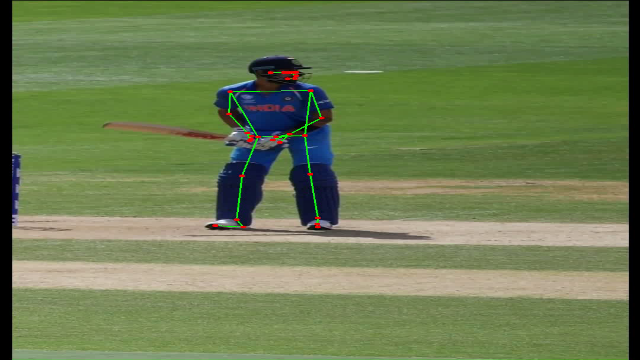

In [10]:
# Cell 7: Create skeleton overlay video
print("Creating skeleton overlay video...")
overlay_video_path = analyzer.create_skeleton_overlay(video_filename, 'skeleton_overlay.mp4')
print("Skeleton overlay created:", overlay_video_path)

# Display a sample frame
cap = cv2.VideoCapture(overlay_video_path)
ret, frame = cap.read()
if ret:
    # Resize for display
    display_frame = cv2.resize(frame, (640, 360))
    cv2_imshow(display_frame)
cap.release()

In [11]:
# Cell 8: Save keypoints to CSV and JSON files
def save_keypoints_to_files(landmarks, video_info, output_prefix='pose_keypoints'):
    """Save extracted keypoints to CSV and JSON formats"""

    # Prepare CSV data
    csv_data = []
    headers = ['frame', 'landmark_id', 'landmark_name', 'x', 'y', 'z', 'visibility']

    for frame_idx, frame_landmarks in enumerate(landmarks):
        if frame_landmarks:
            for landmark_idx, landmark in enumerate(frame_landmarks):
                # Find landmark name
                landmark_name = None
                for name, idx in analyzer.LANDMARK_INDICES.items():
                    if idx == landmark_idx:
                        landmark_name = name
                        break
                if landmark_name is None:
                    landmark_name = f"landmark_{landmark_idx}"

                csv_data.append([
                    frame_idx,
                    landmark_idx,
                    landmark_name,
                    landmark['x'],
                    landmark['y'],
                    landmark['z'],
                    landmark['visibility']
                ])

    # Save to CSV
    csv_filename = f"{output_prefix}.csv"
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)
        writer.writerows(csv_data)

    # Prepare JSON data
    json_data = {
        'video_info': video_info,
        'frames': []
    }

    for frame_idx, frame_landmarks in enumerate(landmarks):
        frame_data = {
            'frame_number': frame_idx,
            'landmarks': frame_landmarks if frame_landmarks else None
        }
        json_data['frames'].append(frame_data)

    # Save to JSON
    json_filename = f"{output_prefix}.json"
    with open(json_filename, 'w') as jsonfile:
        json.dump(json_data, jsonfile, indent=2)

    print("Saved keypoints to", csv_filename, "and", json_filename)

    total_frames = len(landmarks)
    frames_with_landmarks = sum(1 for l in landmarks if l)
    print("Total frames with landmarks:", frames_with_landmarks, "/", total_frames)

    return csv_filename, json_filename

# Save the extracted landmarks
if results:
    csv_file, json_file = save_keypoints_to_files(
        results['landmarks'],
        results['video_info'],
        'cricket_batsman_keypoints'
    )

Saved keypoints to cricket_batsman_keypoints.csv and cricket_batsman_keypoints.json
Total frames with landmarks: 472 / 472


In [12]:
# Cell 9: Define and compute 3 meaningful cricket batting metrics
class CricketBattingMetrics:
    def __init__(self, landmarks, video_info):
        self.landmarks = landmarks
        self.video_info = video_info
        self.fps = video_info['fps']

    def calculate_angle(self, point_a, point_b, point_c):
        """Calculate angle between three points (in degrees)"""
        if not (point_a and point_b and point_c):
            return None

        # Extract coordinates
        a = np.array([point_a['x'], point_a['y']])
        b = np.array([point_b['x'], point_b['y']])
        c = np.array([point_c['x'], point_c['y']])

        # Calculate vectors
        ba = a - b
        bc = c - b

        # Calculate angle
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        cosine_angle = np.clip(cosine_angle, -1, 1)
        angle = np.degrees(np.arccos(cosine_angle))

        return angle

    def get_joint_angle_over_time(self, joint_type='front_knee'):
        """Track joint angles over time during batting stroke"""
        angles = []

        for frame_landmarks in self.landmarks:
            if not frame_landmarks:
                angles.append(None)
                continue

            if joint_type == 'front_knee':
                # Front leg knee angle (important for balance)
                hip = frame_landmarks[analyzer.LANDMARK_INDICES['left_hip']]
                knee = frame_landmarks[analyzer.LANDMARK_INDICES['left_knee']]
                ankle = frame_landmarks[analyzer.LANDMARK_INDICES['left_ankle']]
                angle = self.calculate_angle(hip, knee, ankle)

            elif joint_type == 'back_elbow':
                # Back elbow angle (important for power)
                shoulder = frame_landmarks[analyzer.LANDMARK_INDICES['right_shoulder']]
                elbow = frame_landmarks[analyzer.LANDMARK_INDICES['right_elbow']]
                wrist = frame_landmarks[analyzer.LANDMARK_INDICES['right_wrist']]
                angle = self.calculate_angle(shoulder, elbow, wrist)

            else:
                angle = None

            angles.append(angle)

        # Smooth the angles using Savitzky-Golay filter
        valid_angles = [a for a in angles if a is not None]
        if len(valid_angles) > 10:
            window_size = min(11, len(valid_angles))
            if window_size % 2 == 0:
                window_size -= 1
            smoothed = savgol_filter(valid_angles, window_size, 3)

            # Put smoothed values back
            smoothed_idx = 0
            for i in range(len(angles)):
                if angles[i] is not None:
                    angles[i] = smoothed[smoothed_idx]
                    smoothed_idx += 1

        return angles

    def calculate_stability_metric(self):
        """Measure stability of batter's head position during shot"""
        head_positions = []

        for frame_landmarks in self.landmarks:
            if not frame_landmarks:
                head_positions.append(None)
                continue

            # Use nose position as head reference
            nose = frame_landmarks[analyzer.LANDMARK_INDICES['nose']]
            head_positions.append((nose['x'], nose['y']))

        # Calculate movement variance
        valid_positions = [p for p in head_positions if p]
        if len(valid_positions) < 2:
            return None

        # Convert to numpy array
        positions_array = np.array(valid_positions)

        # Calculate variance in x and y directions
        x_variance = np.var(positions_array[:, 0])
        y_variance = np.var(positions_array[:, 1])

        # Total stability score (lower is better)
        stability_score = np.sqrt(x_variance**2 + y_variance**2)

        # Normalize for readability
        normalized_score = stability_score * 100

        return {
            'stability_score': normalized_score,
            'x_variance': x_variance,
            'y_variance': y_variance,
            'interpretation': 'Lower score indicates more stable head position'
        }

    def calculate_bat_speed_indicator(self):
        """Estimate bat speed by tracking hand movement"""
        hand_positions = []

        for frame_landmarks in self.landmarks:
            if not frame_landmarks:
                hand_positions.append(None)
                continue

            # Use bottom hand wrist position (right hand for right-handed batsman)
            wrist = frame_landmarks[analyzer.LANDMARK_INDICES['right_wrist']]
            hand_positions.append((wrist['x'], wrist['y']))

        # Calculate average speed
        speeds = []
        valid_positions = [p for p in hand_positions if p]

        for i in range(1, len(valid_positions)):
            # Calculate distance moved between frames
            dx = valid_positions[i][0] - valid_positions[i-1][0]
            dy = valid_positions[i][1] - valid_positions[i-1][1]
            distance = np.sqrt(dx**2 + dy**2)

            # Convert to pixels per second
            speed = distance * self.fps
            speeds.append(speed)

        if not speeds:
            return None

        # Calculate metrics
        avg_speed = np.mean(speeds)
        max_speed = np.max(speeds)
        speed_variance = np.var(speeds)

        # Interpretation
        if avg_speed > 0.5:
            speed_rating = "Fast"
        elif avg_speed > 0.3:
            speed_rating = "Moderate"
        else:
            speed_rating = "Slow"

        return {
            'average_speed': avg_speed,
            'max_speed': max_speed,
            'speed_variance': speed_variance,
            'speed_rating': speed_rating,
            'interpretation': 'Higher speeds indicate more powerful shot execution'
        }

    def calculate_range_of_motion(self, joint_type='front_knee'):
        """Measure how much a joint moves during the shot"""
        angles = self.get_joint_angle_over_time(joint_type)
        valid_angles = [a for a in angles if a is not None]

        if not valid_angles:
            return None

        rom = max(valid_angles) - min(valid_angles)

        # Interpretation for cricket
        if joint_type == 'front_knee':
            if rom > 45:
                interpretation = "Good weight transfer and follow-through"
            elif rom > 30:
                interpretation = "Moderate knee bend"
            else:
                interpretation = "Limited knee movement - may affect balance"
        else:
            interpretation = "Range of motion analysis"

        return {
            'range_of_motion': rom,
            'min_angle': min(valid_angles),
            'max_angle': max(valid_angles),
            'interpretation': interpretation
        }

# Initialize metrics calculator
if results:
    metrics_calc = CricketBattingMetrics(results['landmarks'], results['video_info'])
    print("Metrics calculator initialized")

Metrics calculator initialized


In [13]:
# Cell 10: Compute and display all metrics
print("COMPUTING CRICKET BATTING METRICS")
print("=" * 50)

if results:
    # Metric 1: Front Knee Angle Over Time
    print("\n1. FRONT KNEE ANGLE ANALYSIS")
    print("   Why it matters: Proper knee bend ensures balance, weight transfer, and power generation.")
    print("   Optimal range: 120-150 degrees at impact, 90-120 degrees in follow-through.")

    knee_angles = metrics_calc.get_joint_angle_over_time('front_knee')
    valid_knee_angles = [a for a in knee_angles if a is not None]

    if valid_knee_angles:
        avg_knee_angle = np.mean(valid_knee_angles)
        min_knee_angle = min(valid_knee_angles)
        max_knee_angle = max(valid_knee_angles)

        print("   Average knee angle:", f"{avg_knee_angle:.1f}", "degrees")
        print("   Minimum knee angle:", f"{min_knee_angle:.1f}", "degrees")
        print("   Maximum knee angle:", f"{max_knee_angle:.1f}", "degrees")

        # Assess technique
        if min_knee_angle < 100:
            print("   Assessment: Good knee bend detected - indicates proper weight transfer")
        else:
            print("   Assessment: Limited knee bend - may affect balance and power")

    # Metric 2: Stability Analysis
    print("\n2. HEAD STABILITY METRIC")
    print("   Why it matters: Stable head position allows better judgment of line and length.")
    print("   Keeps eyes level and focused on the ball throughout the shot.")

    stability = metrics_calc.calculate_stability_metric()
    if stability:
        print("   Stability Score:", f"{stability['stability_score']:.4f}")
        print("   X-axis variance:", f"{stability['x_variance']:.6f}")
        print("   Y-axis variance:", f"{stability['y_variance']:.6f}")
        print("   Interpretation:", stability['interpretation'])

        if stability['stability_score'] < 0.5:
            print("   Assessment: Excellent head stability - professional technique")
        elif stability['stability_score'] < 1.0:
            print("   Assessment: Good head stability")
        else:
            print("   Assessment: Head movement detected - work on keeping head still")

    # Metric 3: Bat Speed Indicator
    print("\n3. BAT SPEED INDICATOR")
    print("   Why it matters: Faster bat speed generates more power and timing.")
    print("   Allows less reaction time and better stroke execution.")

    bat_speed = metrics_calc.calculate_bat_speed_indicator()
    if bat_speed:
        print("   Average hand speed:", f"{bat_speed['average_speed']:.4f}", "pixels/sec")
        print("   Maximum hand speed:", f"{bat_speed['max_speed']:.4f}", "pixels/sec")
        print("   Speed consistency:", f"{bat_speed['speed_variance']:.6f}")
        print("   Speed rating:", bat_speed['speed_rating'])
        print("   Interpretation:", bat_speed['interpretation'])

    # Additional Metric: Range of Motion
    print("\n4. RANGE OF MOTION ANALYSIS")
    print("   Why it matters: Adequate ROM ensures full stroke execution.")
    print("   Prevents restricted movements and allows proper follow-through.")

    rom_knee = metrics_calc.calculate_range_of_motion('front_knee')
    if rom_knee:
        print("   Front Knee ROM:", f"{rom_knee['range_of_motion']:.1f}", "degrees")
        print("   Min angle:", f"{rom_knee['min_angle']:.1f}", "degrees, Max angle:", f"{rom_knee['max_angle']:.1f}", "degrees")
        print("   Interpretation:", rom_knee['interpretation'])

print("\n" + "=" * 50)
print("All metrics computed successfully")

COMPUTING CRICKET BATTING METRICS

1. FRONT KNEE ANGLE ANALYSIS
   Why it matters: Proper knee bend ensures balance, weight transfer, and power generation.
   Optimal range: 120-150 degrees at impact, 90-120 degrees in follow-through.
   Average knee angle: 131.9 degrees
   Minimum knee angle: 91.7 degrees
   Maximum knee angle: 179.7 degrees
   Assessment: Good knee bend detected - indicates proper weight transfer

2. HEAD STABILITY METRIC
   Why it matters: Stable head position allows better judgment of line and length.
   Keeps eyes level and focused on the ball throughout the shot.
   Stability Score: 0.1917
   X-axis variance: 0.001037
   Y-axis variance: 0.001612
   Interpretation: Lower score indicates more stable head position
   Assessment: Excellent head stability - professional technique

3. BAT SPEED INDICATOR
   Why it matters: Faster bat speed generates more power and timing.
   Allows less reaction time and better stroke execution.
   Average hand speed: 0.1541 pixels/se

CREATING METRICS VISUALIZATIONS


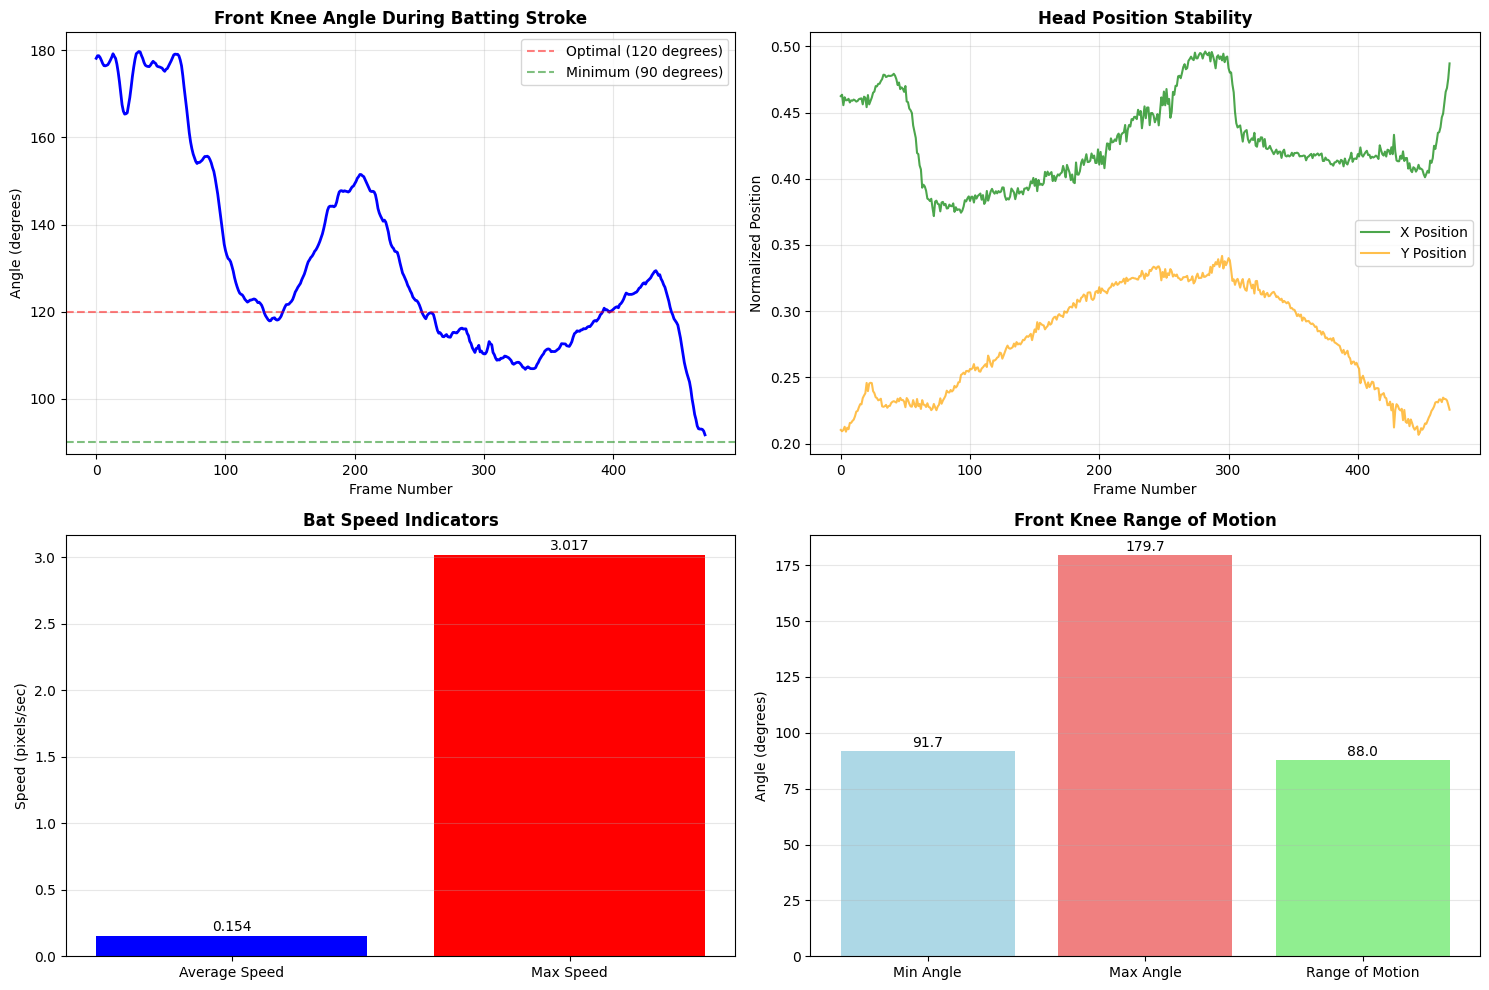

Visualizations saved as 'cricket_batting_metrics.png'


In [14]:
# Cell 11: Create visualizations of the metrics
print("CREATING METRICS VISUALIZATIONS")
import matplotlib.pyplot as plt

if results:
    # Get angles for plotting
    knee_angles = metrics_calc.get_joint_angle_over_time('front_knee')

    # Filter out None values
    valid_knee = [(i, a) for i, a in enumerate(knee_angles) if a is not None]

    if valid_knee:
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Knee Angle Over Time
        frames_k, angles_k = zip(*valid_knee)
        axes[0, 0].plot(frames_k, angles_k, 'b-', linewidth=2)
        axes[0, 0].set_title('Front Knee Angle During Batting Stroke', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Frame Number')
        axes[0, 0].set_ylabel('Angle (degrees)')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axhline(y=120, color='r', linestyle='--', alpha=0.5, label='Optimal (120 degrees)')
        axes[0, 0].axhline(y=90, color='g', linestyle='--', alpha=0.5, label='Minimum (90 degrees)')
        axes[0, 0].legend()

        # Head position stability
        head_x = []
        head_y = []
        frames_h = []

        for i, landmarks in enumerate(results['landmarks']):
            if landmarks:
                nose = landmarks[analyzer.LANDMARK_INDICES['nose']]
                head_x.append(nose['x'])
                head_y.append(nose['y'])
                frames_h.append(i)

        if frames_h:
            axes[0, 1].plot(frames_h, head_x, 'g-', alpha=0.7, label='X Position')
            axes[0, 1].plot(frames_h, head_y, 'orange', alpha=0.7, label='Y Position')
            axes[0, 1].set_title('Head Position Stability', fontsize=12, fontweight='bold')
            axes[0, 1].set_xlabel('Frame Number')
            axes[0, 1].set_ylabel('Normalized Position')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # Bat speed indicator
        bat_speed = metrics_calc.calculate_bat_speed_indicator()
        if bat_speed:
            categories = ['Average Speed', 'Max Speed']
            values = [bat_speed['average_speed'], bat_speed['max_speed']]

            axes[1, 0].bar(categories, values, color=['blue', 'red'])
            axes[1, 0].set_title('Bat Speed Indicators', fontsize=12, fontweight='bold')
            axes[1, 0].set_ylabel('Speed (pixels/sec)')
            axes[1, 0].grid(True, alpha=0.3, axis='y')

            # Add value labels on bars
            for i, v in enumerate(values):
                axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # Range of motion visualization
        rom_knee = metrics_calc.calculate_range_of_motion('front_knee')
        if rom_knee:
            angles_data = [rom_knee['min_angle'], rom_knee['max_angle'], rom_knee['range_of_motion']]
            labels = ['Min Angle', 'Max Angle', 'Range of Motion']

            axes[1, 1].bar(labels, angles_data, color=['lightblue', 'lightcoral', 'lightgreen'])
            axes[1, 1].set_title('Front Knee Range of Motion', fontsize=12, fontweight='bold')
            axes[1, 1].set_ylabel('Angle (degrees)')
            axes[1, 1].grid(True, alpha=0.3, axis='y')

            # Add value labels
            for i, v in enumerate(angles_data):
                axes[1, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('cricket_batting_metrics.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Visualizations saved as 'cricket_batting_metrics.png'")

In [20]:
# ADD THIS CELL AT THE VERY END (after all your existing code)
# Download helper - Simple version
print("\n" + "=" * 60)
print("OUTPUT FILES SUMMARY")
print("=" * 60)

output_files = [
    'skeleton_overlay.mp4',
    'cricket_batsman_keypoints.csv',
    'cricket_batsman_keypoints.json',
    'cricket_batting_metrics.png'
]

# List existing files
existing_files = []
for file in output_files:
    if os.path.exists(file):
        existing_files.append(file)
        print(f"✓ {file}")

if existing_files:
    # Create zip file
    import zipfile
    zip_filename = 'cricket_pose_analysis_output.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in existing_files:
            zipf.write(file)

    print(f"\nCreated zip archive: {zip_filename}")

    # Auto-download without prompt
    try:
        from google.colab import files
        print("Starting download...")
        files.download(zip_filename)
    except Exception as e:
        print(f"Download error: {e}")
        print(f"Manual download: Click folder icon -> find '{zip_filename}' -> Download")

else:
    print("No output files found yet. Run all processing cells first.")

print("=" * 60)


OUTPUT FILES SUMMARY
✓ skeleton_overlay.mp4
✓ cricket_batsman_keypoints.csv
✓ cricket_batsman_keypoints.json
✓ cricket_batting_metrics.png

Created zip archive: cricket_pose_analysis_output.zip
Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>